In [1]:
#!/usr/bin/python3
# -*- coding: utf-8 -*-

import IPython, ipympl
import time
import os, sys
import re
import glob
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
import random
import PIL.Image as Image
from skimage import color
from skimage import io

from fun_map import *
from fun_gui import *
import ipywidgets as widgets

########## Input 
dir_path = '/home/etsai/BNL/Research/KY_platelets/saxs/analysis/'
dir_path = '/home/etsai/BNL/Users/SMI/CMurray/2018C3_CMurray_data/saxs/analysis/'
feature_args = {#'filename'  : 'large_G1_15mgml_finegrid2*5.00s', # [*] Specify
                #'filename'  : 'medium_as-synth_highC_f*10.00s', 
                'filename'  : 'medium_G1_15mgml_*5.00s', 
                'filename'  : 'medium_G2-2G1_highC_m*10.00s',  #81484, 082969
                #'filename'  : 'medium_G2-3G1_20mgml_x*_y*5.00s', 
                #'filename'  : '14_As-synthesized_DEG_Grid',  #x-0.350_y0.20 #14_As-synthesized_DEG_Grid',
                'exclude': ['072641', '081511',  
                            '0698', '06996', '06997',
                            '074831', '074833'], 
                'feature_id': 1, # ignore
                'map_type': 'xy',
                'log10'  : [0, 1], # [data, plot]
                'verbose': 1,
                'plot_interp':  [ 'linear', 0.001], #None, 'linear'(recommended), 'cubic', 'nearest', pixel in mm
                'subplot': False
               } 

feature_1_args = {'source_dir' : dir_path+'qr_image/', #thumbnails2/
             'ext' : '.npz',
             'targets' : [],  # [190, 43], [*] Choose pixels
             'roi': [1, 'mean'],    # [*] Choose +/- n pixels to include
             }

feature_2_args = {'source_dir' : dir_path+'circular_average/', #'../circular_average/',
             'ext' : '.dat',
             'data_col' : [0, 2],
             'targets' : [0.081], #0.053  # [*] Choose q0 or q0,q1
             'roi': [5, 'mean'],    # [*] Choose the half-width (data points) of the peak q
             'N_peaks_find': 7, 
             }
                   
feature_3_args = {'source_dir' : dir_path+'linecut_angle080/',
             'ext' : '.dat',
             'data_col' : [0, 1],
             'angle_roi': [6, 'mean'], #[6, 'mean'], #[-61,  1], # range [0, 60] or N_fold [6, 'mean']
             'targets': ['argmax','var'], #, 'var', 10, 26, 36, 42 , 57, 59, 69], #'max', #[21] # 'max', 'var', or specify angle 
             'normalize': True, # normalize by sum(I)
             'N_peaks_find': 12, 
             }

feature_4_args = {'source_dir' : dir_path+'circular_average/',
             'ext' : '.dat',
             'data_col' : [0, 2],
             'fit_range': [0.033, 0.042],   
             'chi2_thr': 0,
             'targets': ['b', 'prefactor1', 'x_center1', 'd_spacing_nm', 'grain_size_nm', 'chi2'] #b, prefactor1, x_center1, sigma1, chi2
             }
feature_args.update(feature_1_args=feature_1_args, feature_2_args=feature_2_args, feature_3_args=feature_3_args, feature_4_args=feature_4_args)


## Find matching files
infiles, match_re = get_filematch(feature_args)  


medium_G2-2G1_highC_m*10.00s*.npz
medium_G2-2G1_highC_m*10.00s*.npz
Considering 685 files...
  - Now considering 685 files...


medium_G2-2G1_highC_m*10.00s*.dat
medium_G2-2G1_highC_m*10.00s*.dat
Considering 685 files...
  - Now considering 685 files...
Time = 0.91 s


<IPython.core.display.Javascript object>


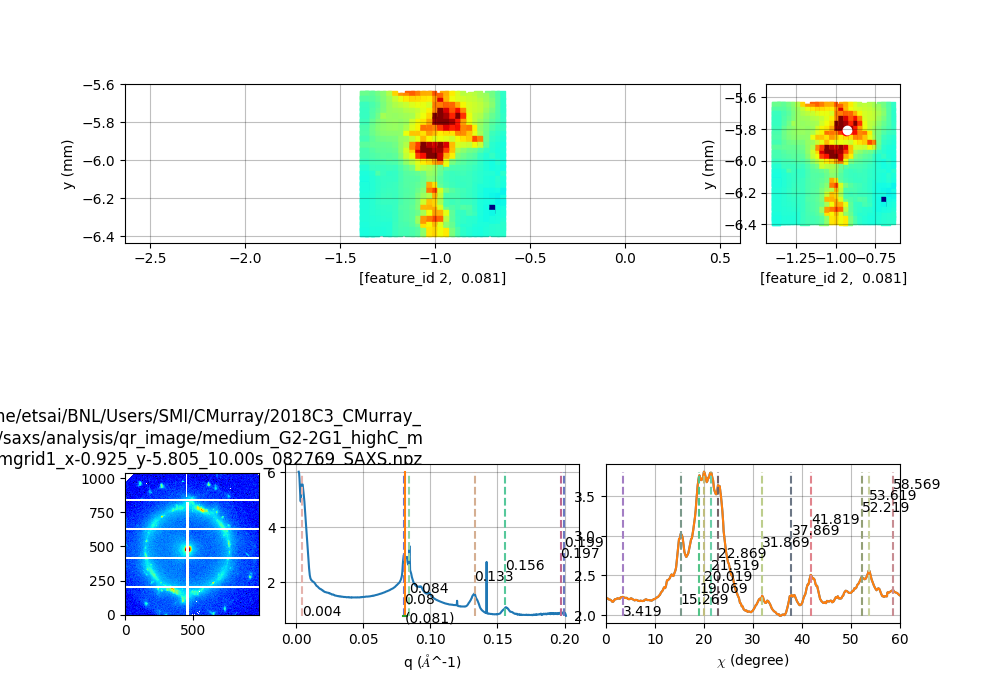

In [2]:
# =============================================================================
# Given x,y and a list of data positions, find the closest point with data
# =============================================================================
def get_closest(pos, post_list):# pos_list is 2 by N
    r_min = 1e10;
    for idx, item in enumerate(post_list[0]):
        x = post_list[0][idx]
        y = post_list[1][idx]
        r = calc_distance(pos, [x, y])
        if r<r_min:
            r_min = r
            xf = x; yf = y
            #idxf = int(idx)
    return xf, yf

def calc_distance(p0, p1):
    r =  math.hypot(p0[0]-p1[0], p0[1]-p1[1])
    return r
# =================


##### Click on map to show data
feature_args.update(feature_id = 2);
infiles, match_re = get_filematch(feature_args) 
t0 = time.time()
features_map = get_map(infiles, match_re, feature_args) 
print('Time = {:.2f} s'.format(time.time()-t0))
#N_maps = len(features_map['tag'][1])
x_pos = features_map['x_pos']
y_pos = features_map['y_pos']

%matplotlib nbagg
fig = plt.figure(20, figsize=[10,7])
fdim = [3, 5]
axis_font = {'fontname':'Arial', 'size':'8', 'weight':'bold'}
cmap = plt.get_cmap('jet');  feature_args.update(cmap=cmap)   
feature_args['plot_interp'] = [None, 1]

ax1 = plt.subplot2grid((fdim[0], fdim[1]), (0, 0), colspan=4); ax1.cla()
plot_map(features_map, **feature_args)

pos = []
def onclick(event):   
    
    xc = event.xdata; 
    yc = event.ydata 
    xf, yf = get_closest([xc, yc], [x_pos, y_pos])
    
    ax2 = plt.subplot2grid((fdim[0], fdim[1]), (0, 4), colspan=1); ax2.cla()
    plot_map(features_map, **feature_args)
    plt.scatter(xc,yc,color='r') # clicked    
    plt.scatter(xf,yf,color='w') # position found in the data position list
    #ax2.set_aspect('equal')
    
    #infiles = find_file(xf, yf, feature_args)
    #ax = plt.subplot2grid((fdim[0], fdim[1]), (0, 0), colspan=1); 
    #plot_data(infiles[0], **feature_args)
    
    feature_ids = [1,2,3]
    colidx = 0
    for idx, feature_id in enumerate(feature_ids):
        feature_args.update(feature_id=feature_id); 
        infiles = find_file(xf, yf, feature_args)
        
        colspan = 2 if feature_id>1 else 1
        ax2 = plt.subplot2grid((fdim[0], fdim[1]), (2, colidx), colspan=colspan); ax2.cla()
        colidx = colidx+colspan
        if feature_id==1:
            feature_args.update(verbose=1)
            feature_args.update(log10=[0, 1])
        else:
            feature_args.update(verbose=0)
            feature_args.update(log10=[0, 1])
        if infiles!=[]: 
            plot_data(infiles[0], **feature_args)
    
fig.canvas.mpl_connect('button_press_event', onclick)
fig.show()


In [16]:
## Scan range
if False:
    roi_x = [np.min(features_map['x_pos']), np.max(features_map['x_pos'])]
    roi_y = [np.min(features_map['y_pos']), np.max(features_map['y_pos'])]
    print(roi_x)
    print(roi_y)


medium_G1_13mgml_x*5.00s*.dat


<IPython.core.display.Javascript object>


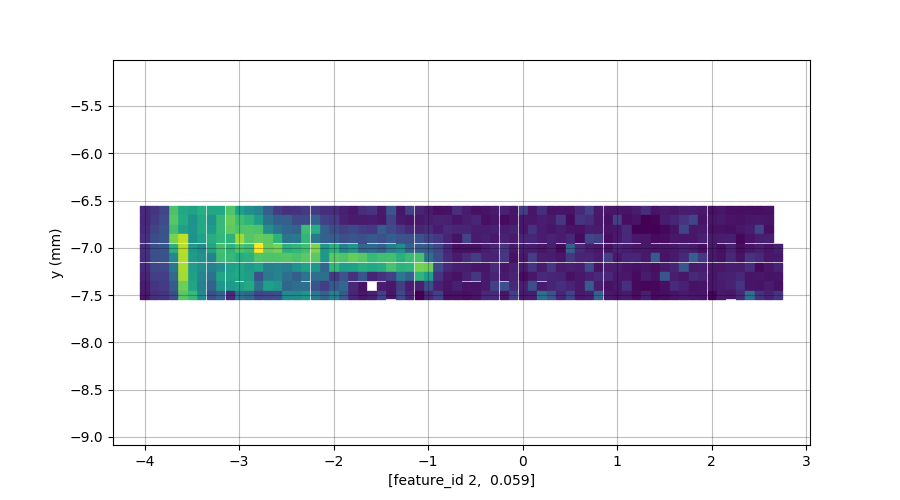

*072444*.dat


<IPython.core.display.Javascript object>


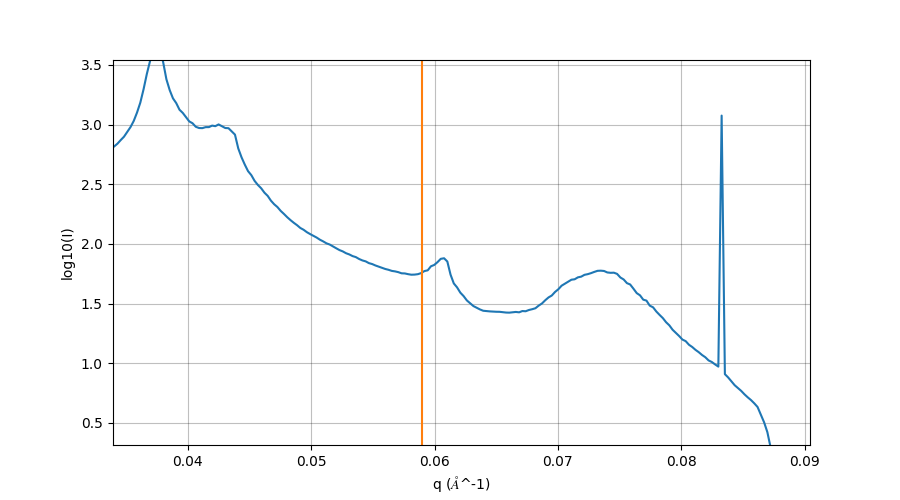

In [22]:
########## Plot all feature map
feature_show = [2]
for idx in feature_show:
    feature_args.update(feature_id=idx); 

    ## Find matching files
    infiles, match_re = get_filematch(feature_args)  

    ## Get map
    features_map = get_map(infiles, match_re, feature_args) 
    
    ## Plot map
    fig = plt.figure(10+feature_args['feature_id'], figsize=[9,5]); plt.clf()
    cmap = plt.get_cmap('viridis');    feature_args.update(cmap=cmap)
    feature_args.update(filename='*072444');   infiles, match_re = get_filematch(feature_args)
    #feature_args.update(plot_interp=['linear', 0.001])
    #feature_args.update(val_stat = [0, 20])
    plot_map(features_map, **feature_args)
    
    fig = plt.figure(20+feature_args['feature_id'], figsize=[9,5]); plt.clf()
    feature_args.update(log10=[0, 1])
    plot_data(infiles[0], **feature_args)


In [3]:
#### bqplot.heatmap
from bqplot import *
import bqplot.pyplot as bplt
from skimage import color
from fun_gui import *

%matplotlib nbagg

def handle_slider_change(change):
    map1.color = color.rgb2gray(io.imread(infiles[change.new]))
    fig.title = infiles[change.new]+' - Scan'+str(change.new)

if feature_args['feature_id']==1:
    value_init = 0;
    img = color.rgb2gray(io.imread(infiles[value_init])); m, n = img.shape              
    x_sc, y_sc, c_sc, ax_x, ax_y, ax_c = bqplot_ax()
    map1 = bplt.heatmap(img, x=np.arange(1,m,1), y=np.arange(1,n,1), scales={'x': x_sc, 'y': y_sc, 'color': c_sc})

    fig = Figure(marks=[map1], animation_duration=100, axes=[ax_x,ax_y,ax_c])
    fig.title = infiles[value_init]
    fig.max_aspect_ratio = 1

    scan_slider = widgets.IntSlider(min=0, max=100, step=1, description='Scan', value=value_init)
    scan_slider.observe(handle_slider_change, 'value')

    play_button = widgets.Play(min=0, max=100, interval=1000)
    widgets.jslink((play_button, 'value'), (scan_slider, 'value'))
    widgets.VBox([widgets.HBox([play_button, scan_slider]), fig])


In [ ]:
##### Slider for viewing all data
def slider_data(scan):      
    ## Plot one data 
    cmap = 'magma';  # 'viridis' 'magma' 'RdYlGn' 'RdYlBu' (https://matplotlib.org/examples/color/colormaps_reference.html)
    feature_args.update(cmap=cmap)

    fdim = [2, 1]
    for idx in [1,2]:
        feature_args.update(feature_id=idx); 
        infiles, match_re = get_filematch(feature_args) 
        ax = plt.subplot2grid((fdim[0], fdim[1]), (idx-1, 0), colspan=1); ax.cla() 
        if infiles!=[]:
            plot_data(infiles[scan], feature_args)  
    plt.show() 

%matplotlib nbagg
fig = plt.figure(10, figsize=[8,8]); plt.clf()
w = widgets.interactive(slider_data, scan=(0,len(infiles)-1))
w